<a href="https://colab.research.google.com/github/raregem-AI/Machine-Learning-Projects/blob/main/DSN_BOOTCAMP_NOTEBOOK2_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

hackathon_qualification_path = kagglehub.competition_download('hackathon-qualification')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackathon-qualification/Starter Notebook.ipynb
/kaggle/input/hackathon-qualification/archive/sample_submission.csv
/kaggle/input/hackathon-qualification/archive/train.csv
/kaggle/input/hackathon-qualification/archive/test.csv


In [ ]:
# Install necessary libraries
!pip install -q autogluon.tabular lightautoml catboost xgboost lightgbm tensorflow xlearn scikit-learn

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.datasets import dump_svmlight_file
import random
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from autogluon.tabular import TabularPredictor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import xlearn as xl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.0/399.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 84.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 80.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00:00:0100:01
  

2025-09-14 18:23:54.630005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757874234.859273      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757874234.920269      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def preprocessing(df):

    df = df.fillna('unknown')
    df = df.replace('-', 'dash')

    df['ext_col'] = np.where(df['ext_col']=='BLACK', 'Black', df['ext_col'])
    df['ext_col'] = np.where(np.isin(df['ext_col'], ['Blu', 'BLUE']), 'Blue', df['ext_col'])

    df['clean_title'] = df['clean_title'].map({'Yes': 1, 'unknown': 0}).astype('int8')
    df['accident'] = df['accident'].map({'None reported': 0, 'At least 1 accident or damage reported': 1, 'unknown': 2}).astype('int8')

    df['fuel_type'] = np.where(df['fuel_type']=='-', 'dash', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type']=='not supported', 'unknown', df['fuel_type'])
    # df['age'] = 2024 - df['model_year']

    df['int_col'] = np.where(df['int_col']=='WHITE', 'White', df['int_col'])
    df['int_col'] = np.where(df['int_col']=='BLACK', 'Black', df['int_col'])
    df['int_col'] = np.where(df['int_col']=='ORANGE', 'Orange', df['int_col'])
    df['int_col'] = np.where(df['int_col']=='BEIGE', 'Beige', df['int_col'])
    df['int_col'] = np.where(df['int_col']=='Ebony.', 'Ebony', df['int_col'])
    df['int_col'] = np.where(df['int_col']=='Classic Red', 'Red', df['int_col'])
    df['int_col'] = np.where(df['int_col']=='Parchment.', 'Parchment', df['int_col'])

    df['transmission'] = np.where(df['transmission']=='Automatic', 'A/T', df['transmission'])
    df['transmission'] = np.where(df['transmission']=='Manual', 'M/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='1-Speed Automatic', '1-Speed A/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='2-Speed Automatic', '2-Speed A/T', df['transmission'])
    df['transmission'] = np.where(df['transmission']=='2', '2-Speed A/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='4-Speed Automatic', '4-Speed A/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='5-Speed Automatic', '5-Speed A/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='6-Speed Automatic', '6-Speed A/T', df['transmission'])
    df['transmission'] = np.where(df['transmission']=='6-Speed Manual', '6-Speed M/T', df['transmission'])
    df['transmission'] = np.where(df['transmission']=='6 Speed Mt', '6-Speed M/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='7-Speed Automatic', '7-Speed A/T', df['transmission'])
    df['transmission'] = np.where(df['transmission']=='7-Speed Manual', '7-Speed M/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='8-SPEED A/T', '8-Speed A/T', df['transmission'])
    df['transmission'] = np.where(df['transmission']=='8-SPEED AT', '8-Speed A/T', df['transmission'])
    df['transmission'] = np.where(df['transmission']=='8-Speed Automatic', '8-Speed A/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='9-Speed Automatic', '9-Speed A/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='10-Speed Automatic', '10-Speed A/T', df['transmission'])

    df['transmission'] = np.where(df['transmission']=='SCHEDULED FOR OR IN PRODUCTION', '-', df['transmission'])

    premium_models = ['G90 5.0 Ultimate', 'A8 L 3.0T', 'M4 Base']
    df['model_premium'] = df['model'].isin(premium_models).astype(int)

    premium_brands = ['Audi', 'BMW', 'Mercedes-Benz', 'Lexus', 'Porsche', 'Land Rover', 'Jaguar', 'Cadillac', 'Tesla', 'Volvo', 'Infiniti', 'Lincoln', 'Acura', 'Alfa Romeo', 'Genesis', 'Maserati', 'Bentley', 'Ferrari', 'Lamborghini', 'McLaren', 'Rolls-Royce', 'Bugatti', 'Koenigsegg', 'Pagani']
    df['is_premium_brand2'] = df['brand'].apply(lambda x: any(brand in x for brand in premium_brands)).astype(int)

    df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)

    return df


In [ ]:
## AuthoGleon


In [ ]:
# =========================================================
# 1. Import libraries
# =========================================================
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

# =========================================================
# 2. Load Data
# =========================================================
train = pd.read_csv('/kaggle/input/hackathon-qualification/archive/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/hackathon-qualification/archive/test.csv', index_col=0)

# =========================================================
# 3. Mark categorical features
# =========================================================
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# =========================================================
# 4. Convert to TabularDataset
# =========================================================
train = TabularDataset(train)
target = 'price'
metric = 'root_mean_squared_error'

# =========================================================
# 5. Define hyperparameters
# =========================================================
hyperparameters = {
    'GBM': [
        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
        {'num_boost_round': 1000, 'learning_rate': 0.01, 'ag_args': {'name_suffix': 'LR01'}},
        {'num_boost_round': 300, 'learning_rate': 0.1, 'ag_args': {'name_suffix': 'LR1'}},
    ],
    'XGB': [
        {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'tree_method': 'gpu_hist', 'ag_args': {'name_suffix': 'XGB1'}},
        {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 8, 'tree_method': 'gpu_hist', 'ag_args': {'name_suffix': 'XGB2'}},
    ],
    'CAT': [
        {'iterations': 500, 'depth': 6, 'learning_rate': 0.05, 'task_type': 'GPU', 'ag_args': {'name_suffix': 'CB1'}},
        {'iterations': 1000, 'depth': 8, 'learning_rate': 0.01, 'task_type': 'GPU', 'ag_args': {'name_suffix': 'CB2'}},
    ],
    'RF': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'RF1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'RF2'}},
    ],
    'XT': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'XT1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'XT2'}},
    ],
    'KNN': [
        {'weights': 'uniform', 'n_neighbors': 5, 'ag_args': {'name_suffix': 'KNN1'}},
        {'weights': 'distance', 'n_neighbors': 10, 'ag_args': {'name_suffix': 'KNN2'}},
    ],
    'NN_TORCH': [
        {'num_epochs': 50, 'trainer_kwargs': {'device': 'cuda'}, 'ag_args': {'name_suffix': 'NN1'}},
        {'num_epochs': 100, 'trainer_kwargs': {'device': 'cuda'}, 'ag_args': {'name_suffix': 'NN2'}},
    ],
    'LinearModel': [{}],
}

# =========================================================
# 6. Train AutoGluon predictor
# =========================================================
time_limit = 3 * 3600  # 3 hours
predictor = TabularPredictor(label=target, eval_metric=metric).fit(
    train_data=train,
    time_limit=time_limit,
    hyperparameters=hyperparameters,
    presets='best_quality',
    num_bag_folds=5,
    num_bag_sets=3,
    num_stack_levels=2
)

# =========================================================
# 7. Leaderboard & RMSE stats
# =========================================================
leaderboard = predictor.leaderboard(silent=True)
leaderboard["RMSE"] = -leaderboard["score_val"]  # convert to positive RMSE

# Average RMSE
avg_rmse = leaderboard["RMSE"].mean()
print(f"Average RMSE across all models: {avg_rmse:.2f}")

# Best/Worst RMSE
print(f"Best RMSE: {leaderboard['RMSE'].min():.2f}")
print(f"Worst RMSE: {leaderboard['RMSE'].max():.2f}")

# =========================================================
# 8. Create Top-N ensemble (optional)
# =========================================================
top_n = 10
top_models = leaderboard.nsmallest(top_n, "RMSE")["model"].tolist()
predictor_topN = predictor.refit_full(models=top_models)

leaderboard_topN = predictor_topN.leaderboard(silent=True)
leaderboard_topN["RMSE"] = -leaderboard_topN["score_val"]
avg_rmse_topN = leaderboard_topN["RMSE"].mean()
print(f"Average RMSE across top {top_n} models: {avg_rmse_topN:.2f}")

# =========================================================
# 9. Make predictions & create submission
# =========================================================
y_pred = predictor_topN.predict(test)

# If 'id' is the index in test dataset
submission = pd.DataFrame({
    'id': test.index,
    'price': y_pred
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


In [ ]:
hyperparameters = {
    'GBM': [
        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
        {'num_boost_round': 1000, 'learning_rate': 0.01, 'ag_args': {'name_suffix': 'LR01'}},
        {'num_boost_round': 300, 'learning_rate': 0.1, 'ag_args': {'name_suffix': 'LR1'}},
    ],
    'XGB': [
        {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'tree_method': 'gpu_hist', 'ag_args': {'name_suffix': 'XGB1'}},
        {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 8, 'tree_method': 'gpu_hist', 'ag_args': {'name_suffix': 'XGB2'}},
    ],
    'CAT': [
        {'iterations': 500, 'depth': 6, 'learning_rate': 0.05, 'task_type': 'GPU', 'ag_args': {'name_suffix': 'CB1'}},
        {'iterations': 1000, 'depth': 8, 'learning_rate': 0.01, 'task_type': 'GPU', 'ag_args': {'name_suffix': 'CB2'}},
    ],
    'RF': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'RF1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'RF2'}},
    ],
    'XT': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'XT1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'XT2'}},
    ],
    'KNN': [
        {'weights': 'uniform', 'n_neighbors': 5, 'ag_args': {'name_suffix': 'KNN1'}},
        {'weights': 'distance', 'n_neighbors': 10, 'ag_args': {'name_suffix': 'KNN2'}},
    ],
    'NN_TORCH': [
        {'num_epochs': 50, 'trainer_kwargs': {'device': 'cuda'}, 'ag_args': {'name_suffix': 'NN1'}},
        {'num_epochs': 100, 'trainer_kwargs': {'device': 'cuda'}, 'ag_args': {'name_suffix': 'NN2'}},
    ],
    'LinearModel': [{}],
}

In [ ]:
hyperparameters=hyperparameters,
    presets='best_quality',
    num_bag_folds=5,
    num_bag_sets=3,
    num_stack_levels=2

In [ ]:
train = pd.read_csv('/kaggle/input/hackathon-qualification/archive/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/hackathon-qualification/archive/test.csv', index_col=0)

train = preprocessing(train)
test = preprocessing(test)

cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']
for i in cat_cols:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer

# train = TabularDataset(train)
# target = 'price'
# metric = 'root_mean_squared_error'
# #time_limit = 1800
# time_limit = 1*3600

# predictor = TabularPredictor(label=target, eval_metric=metric).fit(train,
#                                                                    time_limit=time_limit,
#                                                                    #hyperparameters=hyperparameters,
#                                                                    presets='best_quality',
#                                                                   num_bag_folds=5,
#                                                                    num_bag_sets=3,
#                                                                     num_stack_levels=2
#                                                                   )

predictor = TabularPredictor(
    label=target,
    eval_metric='root_mean_squared_error'
).fit(
    train_data=train,
    presets='best_quality',
    num_bag_folds=2,     # reduce bagging for faster training
    num_bag_sets=1,      # reduce repetitions
    num_stack_levels=1,  # simpler stacking
    time_limit=5*60        # 10 minutes max (use 300 for 5 minutes)
)

print(predictor.leaderboard())


# =========================================================
leaderboard = predictor.leaderboard(silent=True)
leaderboard["RMSE"] = -leaderboard["score_val"]  # convert to positive RMSE

# Average RMSE
avg_rmse = leaderboard["RMSE"].mean()
print(f"Average RMSE across all models: {avg_rmse:.2f}")

# Best/Worst RMSE
print(f"Best RMSE: {leaderboard['RMSE'].min():.2f}")
print(f"Worst RMSE: {leaderboard['RMSE'].max():.2f}")

# =========================================================
# 8. Create Top-N ensemble (optional)
# =========================================================
# top_n = 10
# top_models = leaderboard.nsmallest(top_n, "RMSE")["model"].tolist()
# predictor_topN = predictor.refit_full(models=top_models)

# leaderboard_topN = predictor_topN.leaderboard(silent=True)
# leaderboard_topN["RMSE"] = -leaderboard_topN["score_val"]
# avg_rmse_topN = leaderboard_topN["RMSE"].mean()
# print(f"Average RMSE across top {top_n} models: {avg_rmse_topN:.2f}")



# model     score_val              eval_metric  \
# 0           WeightedEnsemble_L3 -72366.956703  root_mean_squared_error
# 1          CatBoost_r137_BAG_L2 -72405.897831  root_mean_squared_error
# 2               CatBoost_BAG_L2 -72410.839807  root_mean_squared_error
# 3           CatBoost_r13_BAG_L2 -72417.946698  root_mean_squared_error
# 4          CatBoost_r177_BAG_L2 -72435.256638  root_mean_squared_error
# ..                          ...           ...                      ...
# 110   NeuralNetTorch_r22_BAG_L1 -90209.439329  root_mean_squared_error
# 111   NeuralNetTorch_r31_BAG_L1 -90209.512547  root_mean_squared_error
# 112  NeuralNetTorch_r158_BAG_L1 -90209.543224  root_mean_squared_error
# 113   NeuralNetTorch_r86_BAG_L1 -90209.558475  root_mean_squared_error
# 114   NeuralNetTorch_r86_BAG_L2 -90209.558475  root_mean_squared_error


No path specified. Models will be saved in: "AutogluonModels/ag-20250914_222613"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       27.90 GB / 31.35 GB (89.0%)
Disk Space Avail:   15.02 GB / 19.52 GB (77.0%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=2, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optim

                 model     score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L3 -72853.068831  root_mean_squared_error       1.607244   
1    LightGBMXT_BAG_L2 -72912.164000  root_mean_squared_error       1.601233   
2  WeightedEnsemble_L2 -72935.291131  root_mean_squared_error       1.013365   
3    LightGBMXT_BAG_L1 -72939.845129  root_mean_squared_error       0.676145   
4      LightGBM_BAG_L1 -73488.583190  root_mean_squared_error       0.332337   
5      LightGBM_BAG_L2 -73677.666303  root_mean_squared_error       1.277120   

    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  13.582028                0.006011           0.157480            3   
1  13.424547                0.592751           4.530493            2   
2   8.999590                0.004883           0.105536            2   
3   4.581962                0.676145           4.581962            1   
4   4.312092                0.332337           4.312092            1   
5  12.9

In [ ]:
leaderboard = predictor.leaderboard(silent=True)

# Convert negative RMSE back to positive
leaderboard["RMSE"] = -leaderboard["score_val"]

# Compute average RMSE
avg_rmse = leaderboard["RMSE"].mean()
print("Average RMSE across all models:", avg_rmse)


Average RMSE across all models: 73134.4364306385


In [ ]:
leaderboard = predictor.leaderboard(silent=True)

# Convert negative RMSE back to positive
leaderboard["RMSE"] = -leaderboard["score_val"]

# Average RMSE across all models
avg_rmse = leaderboard["RMSE"].sum() / leaderboard["RMSE"].count()
print("Average RMSE (single score):", avg_rmse)


Average RMSE (single score): 73134.4364306385


In [ ]:
test = test.reset_index()

In [ ]:
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,model_premium,is_premium_brand2,horsepower
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,0,1,0,0,240.0
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,0,1,0,0,395.0
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed A/T,White,Ebony,0,0,0,0,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,A/T,Silician Yellow,Black,0,0,0,1,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,0,1,0,1,252.0


In [ ]:
#y_pred = predictor.predict(test)
y_pred = predictor.predict(test)

In [ ]:
y_pred.isna().sum()

0

In [ ]:
ss=pd.read_csv("/kaggle/input/hackathon-qualification/archive/sample_submission.csv")

In [ ]:
ss.head()

,id,price
0,188533,43878.016
1,188534,43878.016
2,188535,43878.016
3,188536,43878.016
4,188537,43878.016


In [ ]:
submission = pd.DataFrame({
    "id": test["id"],        # replace with the correct ID column in your dataset
    "price": y_pred      # replace with the required target column name
})


In [ ]:
submission

,id,price
0,188533,19127.648438
1,188534,79457.265625
2,188535,55377.484375
3,188536,33236.734375
4,188537,30880.402344
...,...,...
125685,314218,28661.683594
125686,314219,51977.582031
125687,314220,23082.570312
125688,314221,18468.945312


In [ ]:
submission.to_csv("submission_AuthoGleon_2.csv", index=False)

In [ ]:
submission.head()

,id,price
0,188533,17558.460938
1,188534,80944.164062
2,188535,55606.019531
3,188536,29533.761719
4,188537,30612.097656


In [ ]:
# Evaluate on the validation set AutoGluon held out
perf = predictor.leaderboard(silent=True)
print(perf)


                    model     score_val              eval_metric  \
0     WeightedEnsemble_L3 -72623.411890  root_mean_squared_error   
1     WeightedEnsemble_L2 -72654.483572  root_mean_squared_error   
2       LightGBMXT_BAG_L2 -72693.063191  root_mean_squared_error   
3       LightGBMXT_BAG_L1 -72815.716961  root_mean_squared_error   
4         CatBoost_BAG_L1 -72825.974781  root_mean_squared_error   
5         LightGBM_BAG_L2 -73087.137877  root_mean_squared_error   
6         LightGBM_BAG_L1 -73132.020388  root_mean_squared_error   
7  RandomForestMSE_BAG_L1 -77659.656851  root_mean_squared_error   

   pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  \
0      12.221531  701.238736                0.004771           0.239150   
1      11.299921  665.727772                0.004511           0.224128   
2      11.884706  683.699911                0.589296          18.196268   
3       1.445150   24.309619                1.445150          24.309619   
4       0.74

In [ ]:
test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,model_premium,is_premium_brand2,horsepower
id,,,,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,0,1,0,0,240.0
188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,0,1,0,0,395.0
188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed A/T,White,Ebony,0,0,0,0,NaN
188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,A/T,Silician Yellow,Black,0,0,0,1,NaN
188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,0,1,0,1,252.0


In [ ]:
y_pred = predictor.predict(test)


In [ ]:
print(test.columns.tolist())


['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'model_premium', 'is_premium_brand2', 'horsepower']


# More Than Twenty 20 models for Diversity


In [ ]:
# 'lambda': 0.03880258557285165,
#      'alpha': 0.02129832295514386,
#      'colsample_bytree': 0.4,
#      'subsample': 0.7,
#      'learning_rate': 0.014,
#      'max_depth': 17,
#      'random_state': 2020,
#      'min_child_weight': 85,
#      'n_estimators': 10000,
#      'early_stopping_rounds': 200,

In [ ]:
# Install necessary libraries
!pip install -q autogluon.tabular lightautoml catboost xgboost lightgbm tensorflow xlearn scikit-learn

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.datasets import dump_svmlight_file
import random
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from autogluon.tabular import TabularPredictor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import xlearn as xl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 14.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.0/399.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 104.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 82.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01


2025-09-14 14:15:41.972481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757859342.122627      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757859342.163504      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# =========================================================
# 1. Import libraries
# =========================================================
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

# =========================================================
# 2. Load Data
# =========================================================
train = pd.read_csv('/kaggle/input/hackathon-qualification/archive/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/hackathon-qualification/archive/test.csv', index_col=0)

# =========================================================
# 3. Mark categorical features
# =========================================================
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# =========================================================
# 4. Convert to TabularDataset
# =========================================================
train = TabularDataset(train)
target = 'price'
metric = 'root_mean_squared_error'

# =========================================================
# 5. Define hyperparameters
# =========================================================
hyperparameters = {
    'GBM': [
        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
        {'num_boost_round': 1000, 'learning_rate': 0.01, 'ag_args': {'name_suffix': 'LR01'}},
        {'num_boost_round': 300, 'learning_rate': 0.1, 'ag_args': {'name_suffix': 'LR1'}},
    ],
    'XGB': [
        {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'tree_method': 'gpu_hist', 'ag_args': {'name_suffix': 'XGB1'}},
        {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 8, 'tree_method': 'gpu_hist', 'ag_args': {'name_suffix': 'XGB2'}},
    ],
    'CAT': [
        {'iterations': 500, 'depth': 6, 'learning_rate': 0.05, 'task_type': 'GPU', 'ag_args': {'name_suffix': 'CB1'}},
        {'iterations': 1000, 'depth': 8, 'learning_rate': 0.01, 'task_type': 'GPU', 'ag_args': {'name_suffix': 'CB2'}},
    ],
    'RF': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'RF1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'RF2'}},
    ],
    'XT': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'XT1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'XT2'}},
    ],
    'KNN': [
        {'weights': 'uniform', 'n_neighbors': 5, 'ag_args': {'name_suffix': 'KNN1'}},
        {'weights': 'distance', 'n_neighbors': 10, 'ag_args': {'name_suffix': 'KNN2'}},
    ],
    'NN_TORCH': [
        {'num_epochs': 50, 'trainer_kwargs': {'device': 'cuda'}, 'ag_args': {'name_suffix': 'NN1'}},
        {'num_epochs': 100, 'trainer_kwargs': {'device': 'cuda'}, 'ag_args': {'name_suffix': 'NN2'}},
    ],
    'LinearModel': [{}],
}

# =========================================================
# 6. Train AutoGluon predictor
# =========================================================
time_limit = 3 * 3600  # 3 hours
predictor = TabularPredictor(label=target, eval_metric=metric).fit(
    train_data=train,
    time_limit=time_limit,
    hyperparameters=hyperparameters,
    presets='best_quality',
    num_bag_folds=5,
    num_bag_sets=3,
    num_stack_levels=2
)

# =========================================================
# 7. Leaderboard & RMSE stats
# =========================================================
leaderboard = predictor.leaderboard(silent=True)
leaderboard["RMSE"] = -leaderboard["score_val"]  # convert to positive RMSE

# Average RMSE
avg_rmse = leaderboard["RMSE"].mean()
print(f"Average RMSE across all models: {avg_rmse:.2f}")

# Best/Worst RMSE
print(f"Best RMSE: {leaderboard['RMSE'].min():.2f}")
print(f"Worst RMSE: {leaderboard['RMSE'].max():.2f}")

# =========================================================
# 8. Create Top-N ensemble (optional)
# =========================================================
top_n = 10
top_models = leaderboard.nsmallest(top_n, "RMSE")["model"].tolist()
predictor_topN = predictor.refit_full(models=top_models)

leaderboard_topN = predictor_topN.leaderboard(silent=True)
leaderboard_topN["RMSE"] = -leaderboard_topN["score_val"]
avg_rmse_topN = leaderboard_topN["RMSE"].mean()
print(f"Average RMSE across top {top_n} models: {avg_rmse_topN:.2f}")

# =========================================================
# 9. Make predictions & create submission
# =========================================================
y_pred = predictor_topN.predict(test)

# If 'id' is the index in test dataset
submission = pd.DataFrame({
    'id': test.index,
    'price': y_pred
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


No path specified. Models will be saved in: "AutogluonModels/ag-20250914_183328"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       28.96 GB / 31.35 GB (92.4%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=3
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

AssertionError: Learner is already fit.

In [ ]:
# =========================================================
# 1. Import libraries
# =========================================================
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

# =========================================================
# 2. Load Data
# =========================================================
train = pd.read_csv('/kaggle/input/hackathon-qualification/archive/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/hackathon-qualification/archive/test.csv', index_col=0)

# Optional preprocessing
# train = preprocessing(train)
# test = preprocessing(test)

# =========================================================
# 3. Mark categorical features
# =========================================================
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# =========================================================
# 4. Convert to TabularDataset
# =========================================================
train = TabularDataset(train)

# Define target and metric
target = 'price'
metric = 'root_mean_squared_error'

# =========================================================
# 5. Define hyperparameters (diverse models, GPU ready)
# =========================================================
hyperparameters = {
    'GBM': [
        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
        {'num_boost_round': 1000, 'learning_rate': 0.01, 'ag_args': {'name_suffix': 'LR01'}},
        {'num_boost_round': 300, 'learning_rate': 0.1, 'ag_args': {'name_suffix': 'LR1'}},
    ],
    'XGB': [
        {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'tree_method': 'gpu_hist', 'ag_args': {'name_suffix': 'XGB1'}},
        {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 8, 'tree_method': 'gpu_hist', 'ag_args': {'name_suffix': 'XGB2'}},
    ],
    'CAT': [  # Corrected CatBoost key
        {'iterations': 500, 'depth': 6, 'learning_rate': 0.05, 'task_type': 'GPU', 'ag_args': {'name_suffix': 'CB1'}},
        {'iterations': 1000, 'depth': 8, 'learning_rate': 0.01, 'task_type': 'GPU', 'ag_args': {'name_suffix': 'CB2'}},
    ],
    'RF': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'RF1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'RF2'}},
    ],
    'XT': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'XT1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'XT2'}},
    ],
    'KNN': [
        {'weights': 'uniform', 'n_neighbors': 5, 'ag_args': {'name_suffix': 'KNN1'}},
        {'weights': 'distance', 'n_neighbors': 10, 'ag_args': {'name_suffix': 'KNN2'}},
    ],
    'NeuralNetTorch': [
        {'num_epochs': 50, 'trainer_kwargs': {'device': 'cuda'}, 'ag_args': {'name_suffix': 'NN1'}},
        {'num_epochs': 100, 'trainer_kwargs': {'device': 'cuda'}, 'ag_args': {'name_suffix': 'NN2'}},
    ],
    'LinearModel': [{}],
}

# =========================================================
# 6. Train AutoGluon with stacking & bagging (single fit)
# =========================================================
time_limit = 2 * 3600  # 3 hours

predictor_2 = TabularPredictor(label=target, eval_metric=metric).fit(
    train_data=train,
    time_limit=time_limit,
    hyperparameters=hyperparameters,
    presets='best_quality',
    num_bag_folds=5,    # bagging folds
    num_bag_sets=3,     # multiple sets per fold
    num_stack_levels=2  # stacking depth
)

# =========================================================
# 7. Leaderboard and RMSE analysis
# =========================================================
leaderboard = predictor_2.leaderboard(silent=True)
leaderboard["RMSE"] = -leaderboard["score_val"]  # Convert negative to positive

avg_rmse_all = leaderboard["RMSE"].mean()
best_rmse = leaderboard["RMSE"].min()
worst_rmse = leaderboard["RMSE"].max()

print("Full Leaderboard:")
print(leaderboard)
print(f"\nAverage RMSE across all models: {avg_rmse_all:.2f}")
print(f"Best RMSE: {best_rmse:.2f}")
print(f"Worst RMSE: {worst_rmse:.2f}")

# =========================================================
# 8. Keep Top 10 models for ensemble
# =========================================================
top_n = 10
top_models = leaderboard.nsmallest(top_n, "RMSE")["model"].tolist()
predictor_topN = predictor_2.refit_full(models=top_models)

# Leaderboard of top models
leaderboard_topN = predictor_topN.leaderboard(silent=True)
leaderboard_topN["RMSE"] = -leaderboard_topN["score_val"]
avg_rmse_topN = leaderboard_topN["RMSE"].mean()
print(f"\nAverage RMSE across top {top_n} models: {avg_rmse_topN:.2f}")

# =========================================================
# 9. Make predictions on test set
# =========================================================
y_pred = predictor_topN.predict(test)

# =========================================================
# 10. Prepare submission file
# =========================================================
submission = pd.DataFrame({
    "id": test.index,  # test IDs (from index)
    "price": y_pred
})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'")


No path specified. Models will be saved in: "AutogluonModels/ag-20250914_182904"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.06 GB / 31.35 GB (92.7%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=3
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

AssertionError: Learner is already fit.

In [ ]:
# =========================================================
# 1. Import libraries
# =========================================================
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

# =========================================================
# 2. Load Data
# =========================================================
train = pd.read_csv('/kaggle/input/hackathon-qualification/archive/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/hackathon-qualification/archive/test.csv', index_col=0)

# =========================================================
# 3. Mark categorical features
# =========================================================
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# =========================================================
# 4. Convert to TabularDataset
# =========================================================
train = TabularDataset(train)

# Define target + metric
target = 'price'
metric = 'root_mean_squared_error'

# =========================================================
# 5. Define custom hyperparameters (20+ models)
# =========================================================
hyperparameters = {
    'GBM': [
        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
        {'num_boost_round': 1000, 'learning_rate': 0.01, 'ag_args': {'name_suffix': 'LR01'}},
        {'num_boost_round': 300, 'learning_rate': 0.1, 'ag_args': {'name_suffix': 'LR1'}},
    ],
    'XGB': [
        {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'ag_args': {'name_suffix': 'XGB1'}},
        {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 8, 'ag_args': {'name_suffix': 'XGB2'}},
    ],
    'CatBoost': [
        {'iterations': 500, 'depth': 6, 'learning_rate': 0.05, 'ag_args': {'name_suffix': 'CB1'}},
        {'iterations': 1000, 'depth': 8, 'learning_rate': 0.01, 'ag_args': {'name_suffix': 'CB2'}},
    ],
    'RF': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'RF1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'RF2'}},
    ],
    'XT': [
        {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'XT1'}},
        {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'XT2'}},
    ],
    'KNN': [
        {'weights': 'uniform', 'n_neighbors': 5, 'ag_args': {'name_suffix': 'KNN1'}},
        {'weights': 'distance', 'n_neighbors': 10, 'ag_args': {'name_suffix': 'KNN2'}},
    ],
    'NeuralNetTorch': [
        {'num_epochs': 50, 'ag_args': {'name_suffix': 'NN1'}},
        {'num_epochs': 100, 'ag_args': {'name_suffix': 'NN2'}},
    ],
    'LinearModel': {}
}

# =========================================================
# 6. Train AutoGluon with stacking & bagging
# =========================================================
time_limit = 2 * 3600  # 3 hours

predictor = TabularPredictor(label=target, eval_metric=metric).fit(
    train_data=train,
    time_limit=time_limit,
    hyperparameters=hyperparameters,
    presets='best_quality',
    num_bag_folds=5,     # bagging folds
    num_bag_sets=3,      # repeat each fold
    num_stack_levels=2   # stacking depth
)

# =========================================================
# 7. Full leaderboard + RMSE stats
# =========================================================
leaderboard = predictor.leaderboard(silent=True)
leaderboard["RMSE"] = -leaderboard["score_val"]

print("\nFull Leaderboard:")
print(leaderboard[["model", "RMSE"]])

avg_rmse_all = leaderboard["RMSE"].mean()
best_rmse = leaderboard["RMSE"].min()
worst_rmse = leaderboard["RMSE"].max()

print(f"\nAverage RMSE (all models): {avg_rmse_all:.2f}")
print(f"Best RMSE: {best_rmse:.2f}")
print(f"Worst RMSE: {worst_rmse:.2f}")

# =========================================================
# 8. Top N models & refit ensemble
# =========================================================
top_n = 10
top_models = leaderboard.nsmallest(top_n, "RMSE")["model"].tolist()
print(f"\nTop {top_n} models selected for ensemble:\n", top_models)

predictor_topN = predictor.refit_full(models=top_models)

leaderboard_topN = predictor_topN.leaderboard(silent=True)
leaderboard_topN["RMSE"] = -leaderboard_topN["score_val"]
avg_rmse_topN = leaderboard_topN["RMSE"].mean()
print(f"\nAverage RMSE across top {top_n} models: {avg_rmse_topN:.2f}")

# =========================================================
# 9. Weighted Ensemble RMSE (single final score)
# =========================================================
ensemble_models = [m for m in leaderboard_topN["model"] if "WeightedEnsemble" in m]
if ensemble_models:
    ensemble_model_name = ensemble_models[0]
    ensemble_rmse = leaderboard_topN.loc[leaderboard_topN["model"] == ensemble_model_name, "RMSE"].values[0]
    print(f"\nWeighted Ensemble ({ensemble_model_name}) RMSE: {ensemble_rmse:.2f}")
else:
    print("\nNo weighted ensemble found in top models.")

# =========================================================
# 10. Make Predictions on Test + Submission File
# =========================================================

test = test.reset_index()

y_pred = predictor_topN.predict(test)

submission = pd.DataFrame({
    "id": test.index,
    "price": y_pred
})

submission.to_csv("submission.csv", index=False)
print("\n✅ Submission file saved as submission.csv")


No path specified. Models will be saved in: "AutogluonModels/ag-20250914_141724"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       28.99 GB / 31.35 GB (92.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=3
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

AssertionError: Learner is already fit.

In [ ]:
# # =========================================================
# # 1. Import libraries
# # =========================================================
# import pandas as pd
# from autogluon.tabular import TabularDataset, TabularPredictor

# # =========================================================
# # 2. Load Data
# # =========================================================
# train = pd.read_csv('/kaggle/input/hackathon-qualification/archive/train.csv', index_col=0)
# test = pd.read_csv('/kaggle/input/hackathon-qualification/archive/test.csv', index_col=0)

# # (Optional preprocessing function)
# # train = preprocessing(train)
# # test = preprocessing(test)

# # =========================================================
# # 3. Mark categorical features
# # =========================================================
# cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']
# for col in cat_cols:
#     train[col] = train[col].astype('category')
#     test[col] = test[col].astype('category')

# # =========================================================
# # 4. Convert to TabularDataset
# # =========================================================
# train = TabularDataset(train)

# # Define target + metric
# target = 'price'
# metric = 'root_mean_squared_error'

# # =========================================================
# # 5. Define custom hyperparameters
# # =========================================================
# hyperparameters = {
#     'GBM': [
#         {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
#         {'num_boost_round': 1000, 'learning_rate': 0.01, 'ag_args': {'name_suffix': 'LR01'}},
#         {'num_boost_round': 300, 'learning_rate': 0.1, 'ag_args': {'name_suffix': 'LR1'}},
#     ],
#     'XGB': [
#         {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'ag_args': {'name_suffix': 'XGB1'}},
#         {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 8, 'ag_args': {'name_suffix': 'XGB2'}},
#     ],
#     'CatBoost': [
#         {'iterations': 500, 'depth': 6, 'learning_rate': 0.05, 'ag_args': {'name_suffix': 'CB1'}},
#         {'iterations': 1000, 'depth': 8, 'learning_rate': 0.01, 'ag_args': {'name_suffix': 'CB2'}},
#     ],
#     'RF': [
#         {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'RF1'}},
#         {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'RF2'}},
#     ],
#     'XT': [
#         {'n_estimators': 300, 'max_depth': 10, 'ag_args': {'name_suffix': 'XT1'}},
#         {'n_estimators': 500, 'max_depth': 20, 'ag_args': {'name_suffix': 'XT2'}},
#     ],
#     'KNN': [
#         {'weights': 'uniform', 'n_neighbors': 5, 'ag_args': {'name_suffix': 'KNN1'}},
#         {'weights': 'distance', 'n_neighbors': 10, 'ag_args': {'name_suffix': 'KNN2'}},
#     ],
#     'NeuralNetTorch': [
#         {'num_epochs': 50, 'ag_args': {'name_suffix': 'NN1'}},
#         {'num_epochs': 100, 'ag_args': {'name_suffix': 'NN2'}},
#     ],
#     'LinearModel': {},
# }

# # =========================================================
# # 6. Train AutoGluon with stacking & bagging
# # =========================================================
# time_limit = 3 * 3600  # 3 hours (adjust depending on Kaggle resources)

# predictor = TabularPredictor(label=target, eval_metric=metric).fit(
#     train_data=train,
#     time_limit=time_limit,
#     hyperparameters=hyperparameters,
#     presets='best_quality',
#     num_bag_folds=5,     # bagging folds (5 gives more diversity)
#     num_bag_sets=3,      # train each fold multiple times
#     num_stack_levels=2   # stacking depth (2 levels of stacked models)
# )

# # =========================================================
# # 7. View trained models
# # =========================================================
# leaderboard = predictor.leaderboard(silent=True)
# print(leaderboard)


# Importing Libraries

In [ ]:
%%time
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import gc

import holidays

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, GroupKFold
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from ydf import RandomForestLearner, GradientBoostedTreesLearner
import ydf

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, DMatrix
import xgboost as xgb
from catboost import CatBoostRegressor, Pool



import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc

CPU times: user 473 µs, sys: 2 µs, total: 475 µs
Wall time: 505 µs


## Reading Data File

In [ ]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


In [ ]:
df_sub = pd.read_csv("/kaggle/input/hackathon-qualification/archive/sample_submission.csv")

In [ ]:
%%time
train = pd.read_csv('/kaggle/input/hackathon-qualification/archive/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/hackathon-qualification/archive/test.csv', index_col=0)


# # train = pd.read_csv('../input/playground-series-s5e1/train.csv', index_col=0)
# train['date']= pd.to_datetime(train['date'])
# train = train.dropna().reset_index(drop=True)
# # train['num_sold'] = train['num_sold'].fillna(0)

# # test = pd.read_csv('../input/playground-series-s5e1/test.csv', index_col=0)
# test['date'] = pd.to_datetime(test['date'])

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (188533, 12)
The dimension of the test dataset is: (125690, 11)
CPU times: user 741 ms, sys: 20 ms, total: 761 ms
Wall time: 761 ms


In [ ]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
id,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [ ]:
print('--- Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Test ---\n')
print(100*test.isnull().sum() / test.shape[0])

--- Train ---

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64


--- Test ---

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.691543
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.298433
clean_title     11.328666
dtype: float64


# EDA

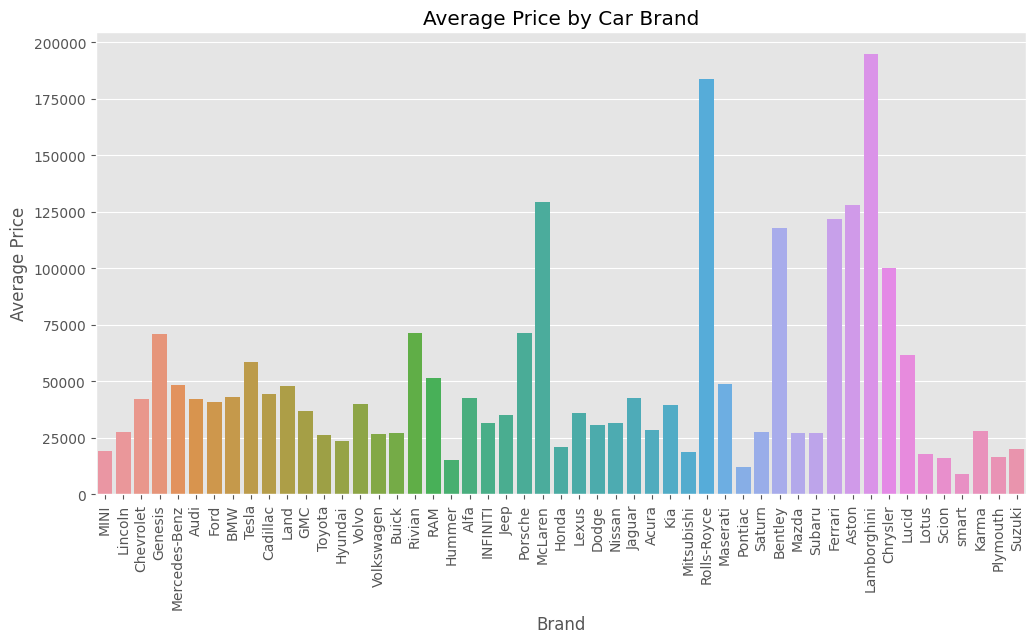

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='price', data=train[:10000], errorbar=None)
plt.title('Average Price by Car Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

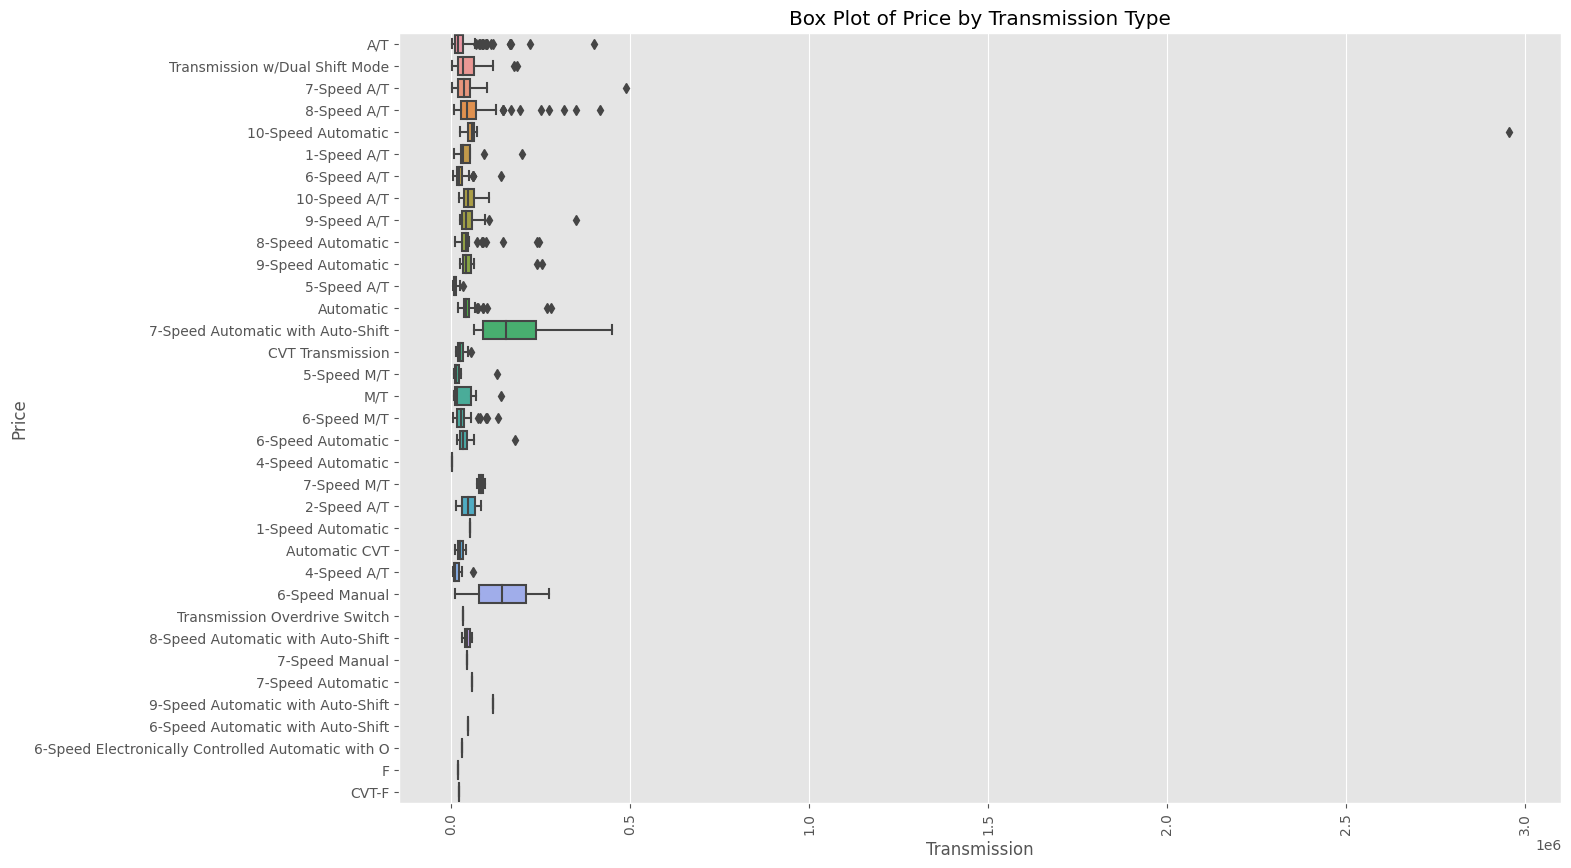

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='price', y='transmission', data=train[:1000],orient='h')
plt.title('Box Plot of Price by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

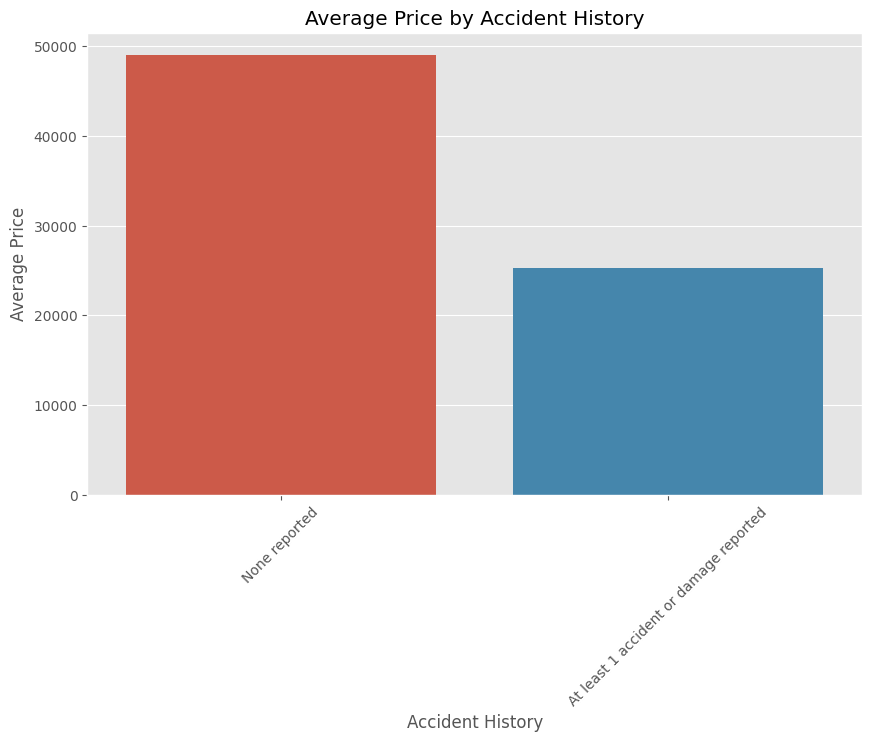

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='accident', y='price', data=train, errorbar=None)
plt.title('Average Price by Accident History')
plt.xlabel('Accident History')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

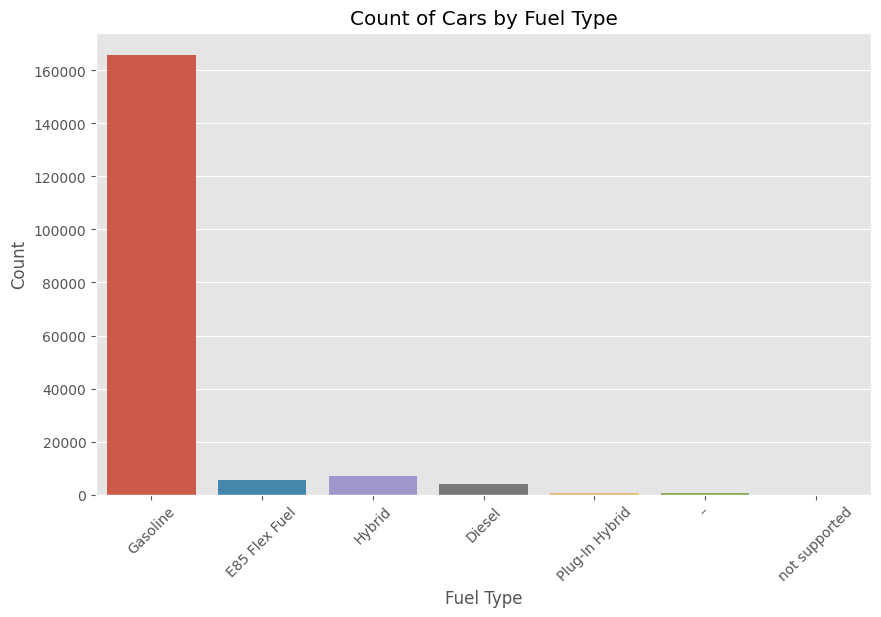

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='fuel_type', data=train)
plt.title('Count of Cars by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

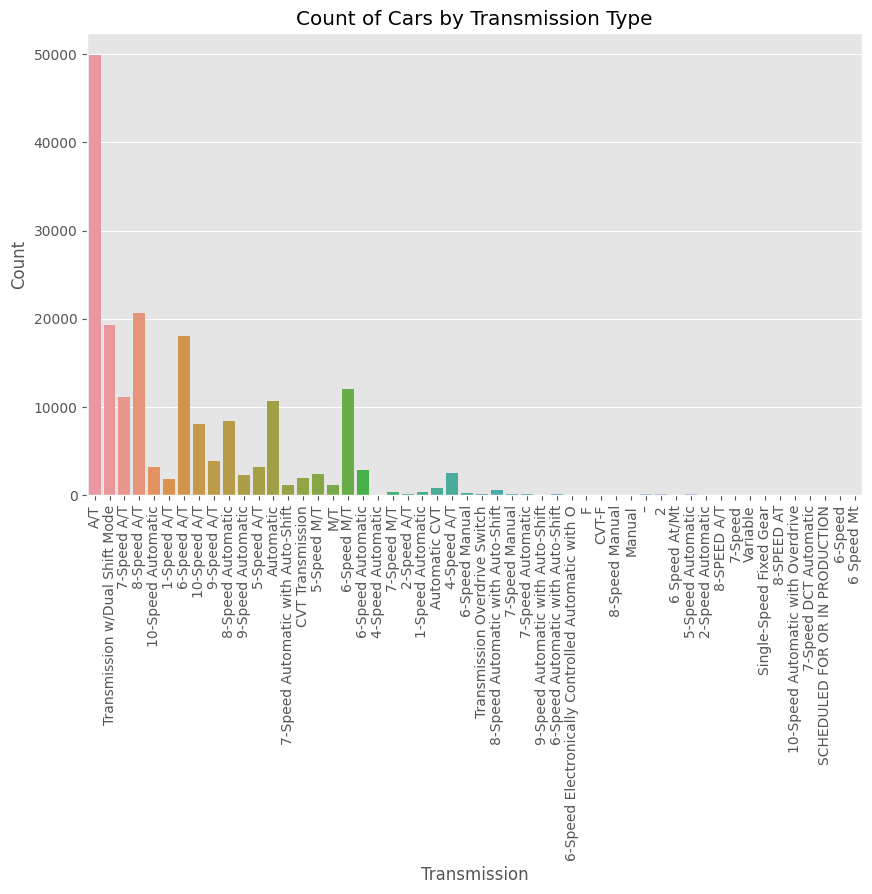

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='transmission', data=train)
plt.title('Count of Cars by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
categorical_columns = train.select_dtypes(include=['object']).columns
unique_values = {col: train[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

gc.collect()

brand: 57 unique values
model: 1897 unique values
fuel_type: 7 unique values
engine: 1117 unique values
transmission: 52 unique values
ext_col: 319 unique values
int_col: 156 unique values
accident: 2 unique values
clean_title: 1 unique values


41784

In [ ]:
categorical_columns = test.select_dtypes(include=['object']).columns
unique_values = {col: test[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

gc.collect()

brand: 55 unique values
model: 1891 unique values
fuel_type: 7 unique values
engine: 1117 unique values
transmission: 52 unique values
ext_col: 317 unique values
int_col: 156 unique values
accident: 2 unique values
clean_title: 1 unique values


0

In [ ]:
missing_train = train.isna().mean() * 100
missing_test = test.isna().mean() * 100

print("Columns in df_train with more than 10% missing values:")
print(missing_train[missing_train > 0])

print("\nColumns in df_test with more than 10% missing values:")
print(missing_test[missing_test > 0])

Columns in df_train with more than 10% missing values:
fuel_type       2.696080
accident        1.300568
clean_title    11.360876
dtype: float64

Columns in df_test with more than 10% missing values:
fuel_type       2.691543
accident        1.298433
clean_title    11.328666
dtype: float64


# FE

In [ ]:
train = preprocessing(train)
test = preprocessing(test)

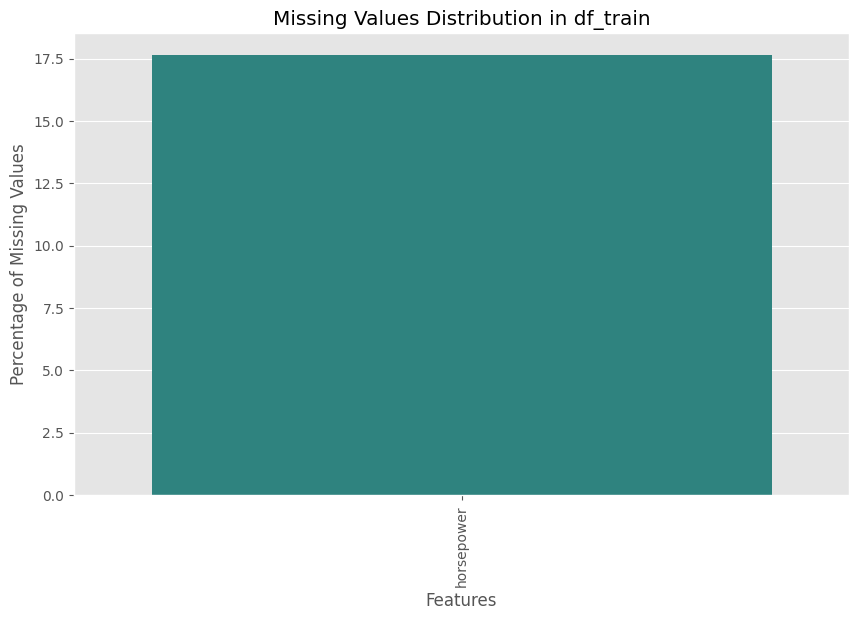

In [ ]:
missing_values = train.isnull().mean() * 100
missing_values = missing_values[missing_values >0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in df_train')
plt.show()

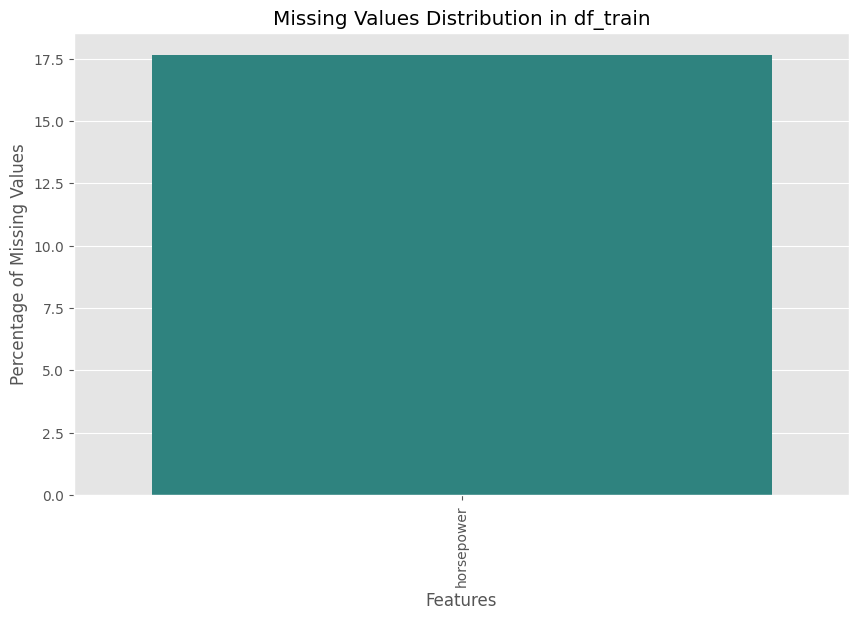

In [ ]:
missing_values = test.isnull().mean() * 100
missing_values = missing_values[missing_values >0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in df_train')
plt.show()

In [ ]:
!pip install dython

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import category_encoders as ce

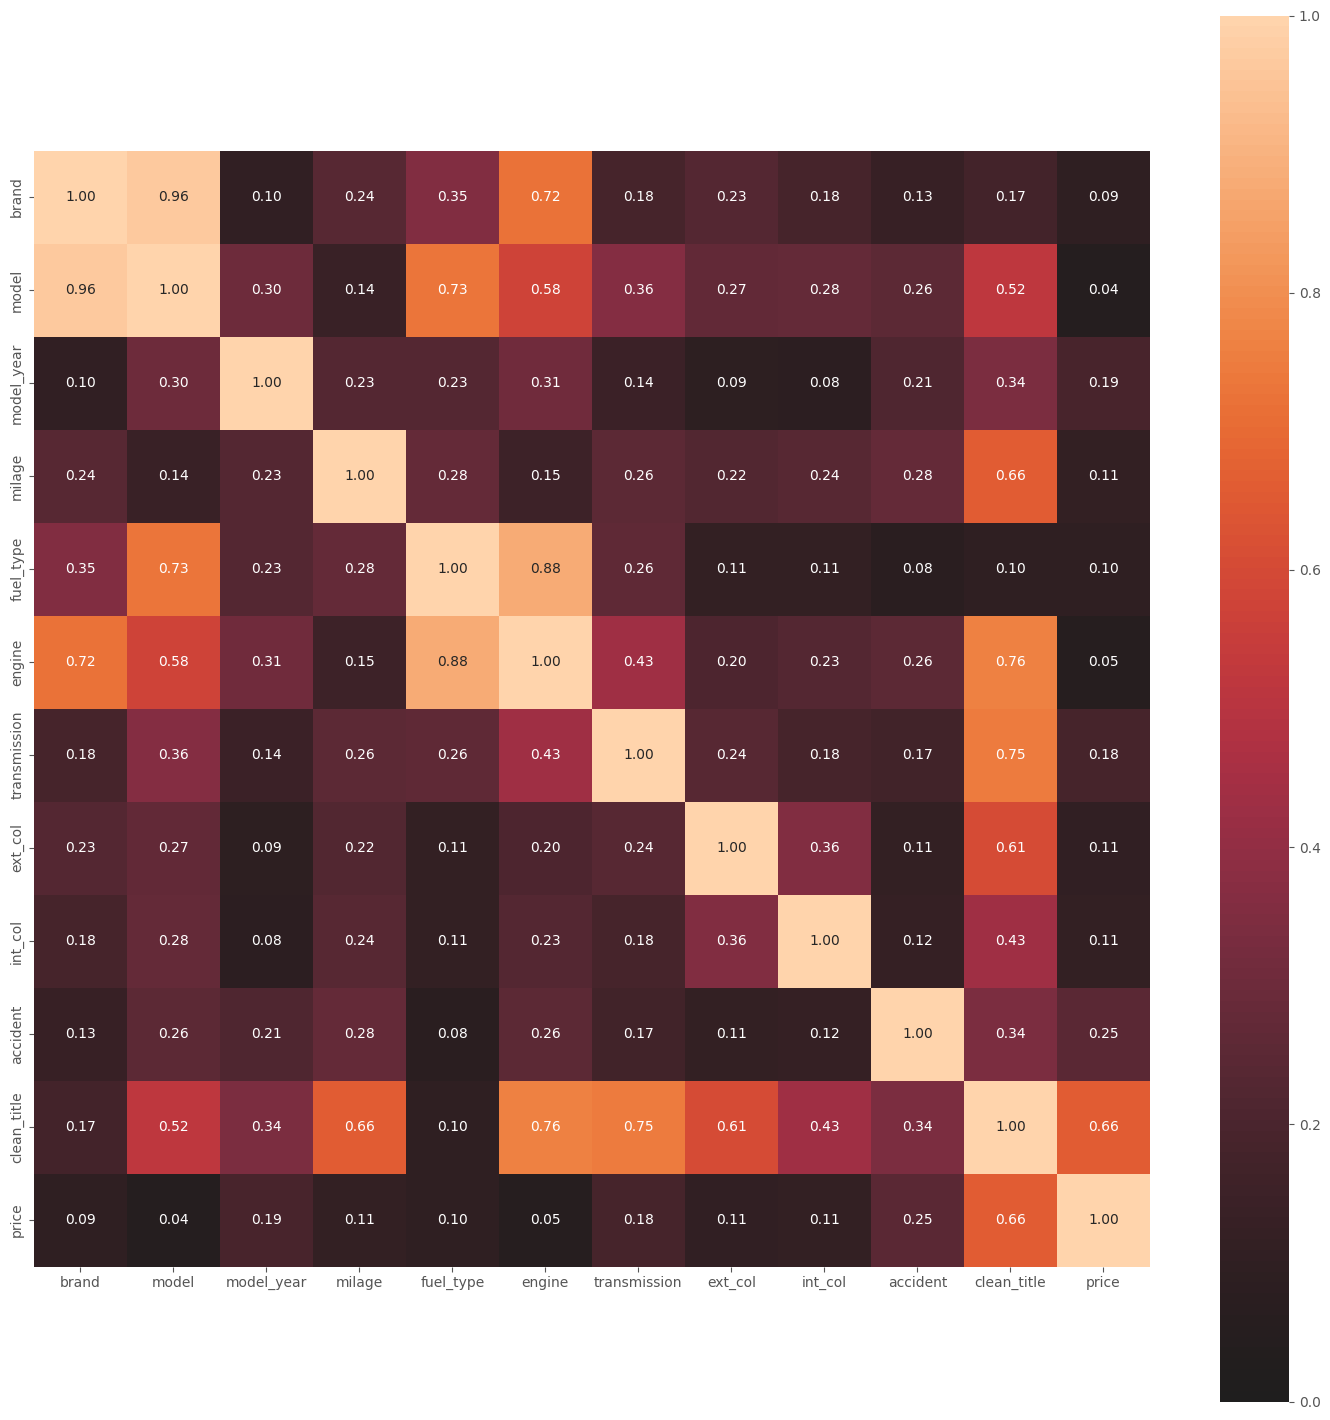

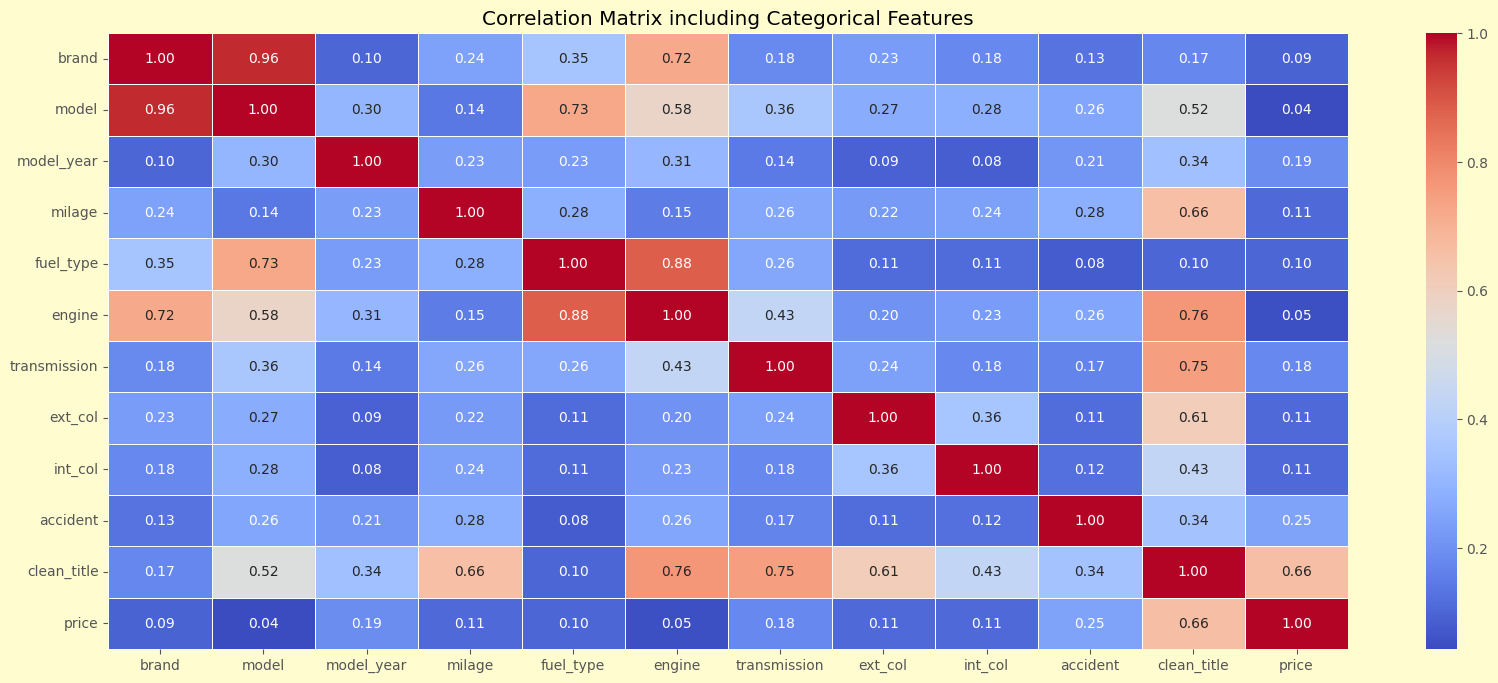

In [ ]:
from dython.nominal import associations

associations_df = associations(train, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0')
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

# FE

In [ ]:
from sklearn.impute import KNNImputer

def knn_impute(df, n_neighbors=5):
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

In [ ]:
df_train_imputed = knn_impute(train, n_neighbors=25)
df_test_imputed = knn_impute(test, n_neighbors=25)

In [ ]:
cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [ ]:
cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [ ]:
df_train_imputed.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,model_premium,is_premium_brand2,horsepower
0,31.0,495.0,2007.0,213000.0,2.0,116.0,24.0,309.0,67.0,0.0,1.0,4200.0,0.0,0.0,172.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,24.0,260.0,8.0,1.0,1.0,4999.0,0.0,1.0,252.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,24.0,35.0,67.0,0.0,1.0,13900.0,0.0,0.0,320.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,32.0,27.0,12.0,0.0,1.0,45000.0,1.0,1.0,420.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,15.0,27.0,8.0,0.0,1.0,97500.0,0.0,1.0,208.0


In [ ]:
df_train_imputed.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'model_premium', 'is_premium_brand2', 'horsepower'],
      dtype='object')

In [ ]:
df_train = df_train_imputed
df_test = df_test_imputed

In [ ]:
df_train.isnull().sum()

brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
model_premium        0
is_premium_brand2    0
horsepower           0
dtype: int64

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

df_train_no_outliers = remove_outliers_iqr(df_train, 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')
df_train_no_outliers.reset_index(drop=True, inplace=True)

In [ ]:
df_train

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,model_premium,is_premium_brand2,horsepower
0,31.0,495.0,2007.0,213000.0,2.0,116.0,24.0,309.0,67.0,0.0,1.0,4200.0,0.0,0.0,172.00
1,28.0,930.0,2002.0,143250.0,2.0,366.0,24.0,260.0,8.0,1.0,1.0,4999.0,0.0,1.0,252.00
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,24.0,35.0,67.0,0.0,1.0,13900.0,0.0,0.0,320.00
3,16.0,758.0,2017.0,19500.0,2.0,863.0,32.0,27.0,12.0,0.0,1.0,45000.0,1.0,1.0,420.00
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,15.0,27.0,8.0,0.0,1.0,97500.0,0.0,1.0,208.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8.0,604.0,2017.0,49000.0,2.0,866.0,32.0,301.0,8.0,0.0,1.0,27500.0,0.0,1.0,420.00
188529,36.0,206.0,2018.0,28600.0,2.0,770.0,19.0,301.0,12.0,1.0,1.0,30000.0,0.0,1.0,385.00
188530,36.0,223.0,2021.0,13650.0,2.0,921.0,15.0,301.0,12.0,0.0,1.0,86900.0,0.0,1.0,469.00
188531,3.0,1471.0,2022.0,13895.0,2.0,512.0,1.0,79.0,12.0,0.0,0.0,84900.0,0.0,1.0,411.36


In [ ]:
df_train_no_outliers.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,model_premium,is_premium_brand2,horsepower
0,28.0,930.0,2002.0,143250.0,2.0,366.0,24.0,260.0,8.0,1.0,1.0,4999.0,0.0,1.0,252.0
1,9.0,1575.0,2002.0,136731.0,1.0,640.0,24.0,35.0,67.0,0.0,1.0,13900.0,0.0,0.0,320.0
2,16.0,758.0,2017.0,19500.0,2.0,863.0,32.0,27.0,12.0,0.0,1.0,45000.0,1.0,1.0,420.0
3,36.0,1077.0,2021.0,7388.0,2.0,259.0,15.0,27.0,8.0,0.0,1.0,97500.0,0.0,1.0,208.0
4,3.0,182.0,2018.0,40950.0,2.0,364.0,24.0,301.0,148.0,0.0,1.0,29950.0,0.0,1.0,252.0


In [ ]:
df_train_no_outliers.isnull().sum()

brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
model_premium        0
is_premium_brand2    0
horsepower           0
dtype: int64

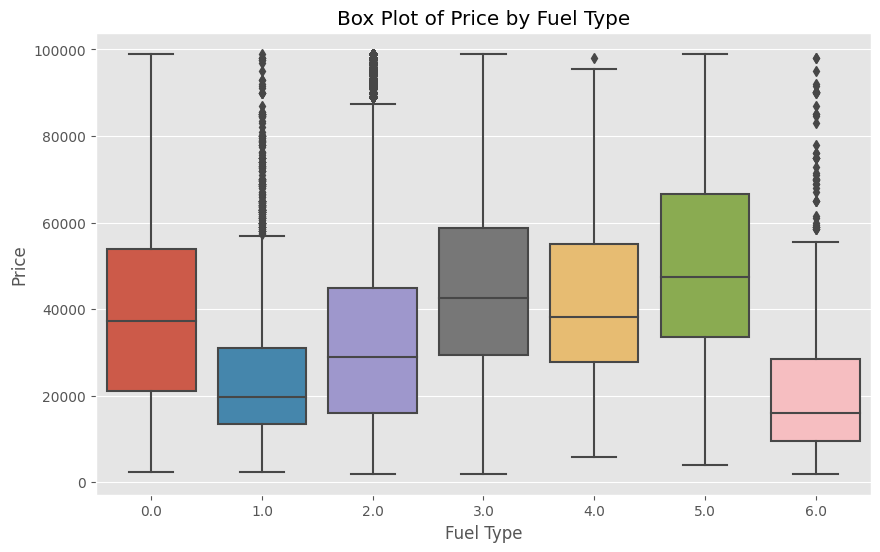

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=df_train_no_outliers)
plt.title('Box Plot of Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

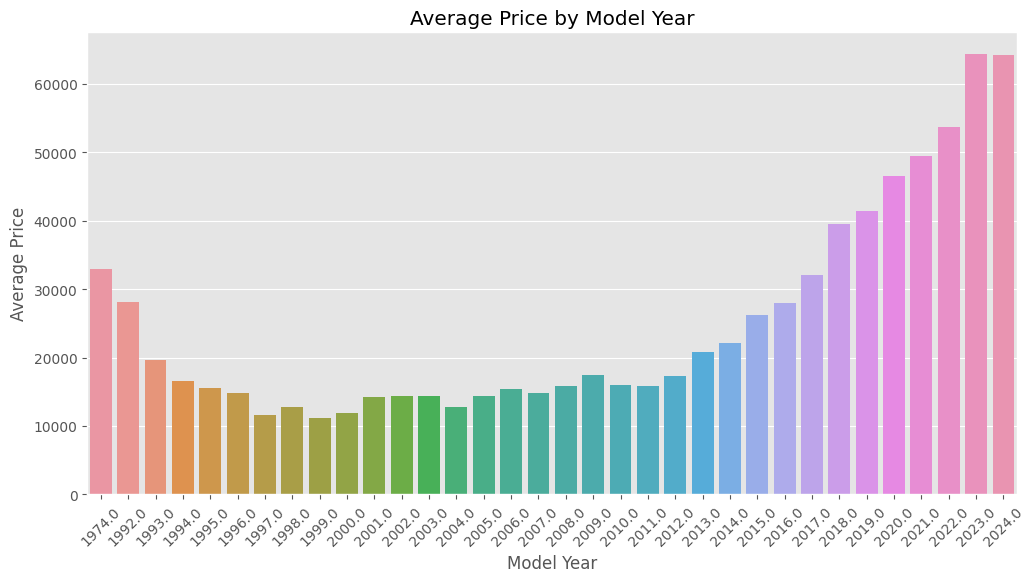

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model_year', y='price', data=df_train_no_outliers, errorbar=None)
plt.title('Average Price by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

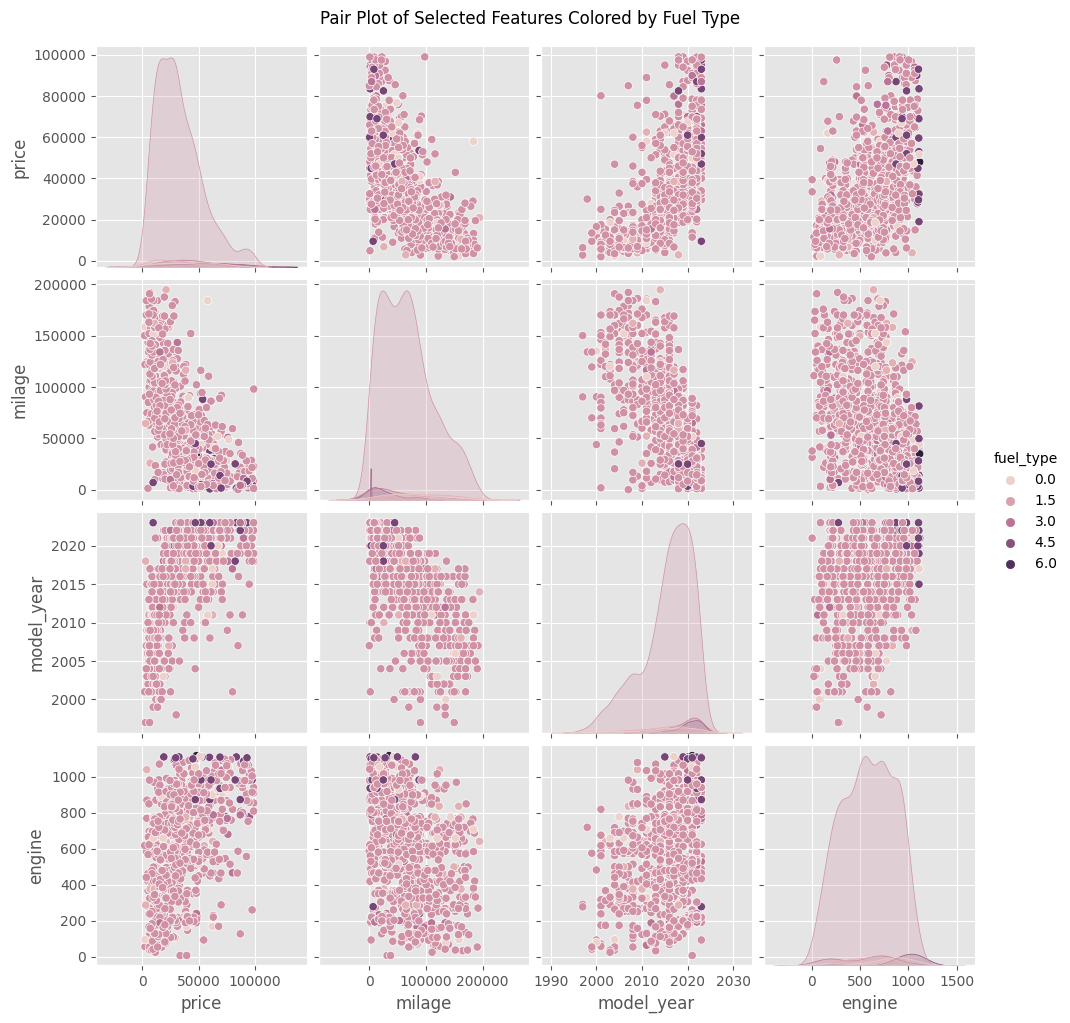

In [ ]:
x = df_train_no_outliers[:1000]
sns.pairplot(x[['price', 'milage', 'model_year', 'engine', 'fuel_type']], hue='fuel_type')
plt.suptitle('Pair Plot of Selected Features Colored by Fuel Type', y=1.02)
plt.show()

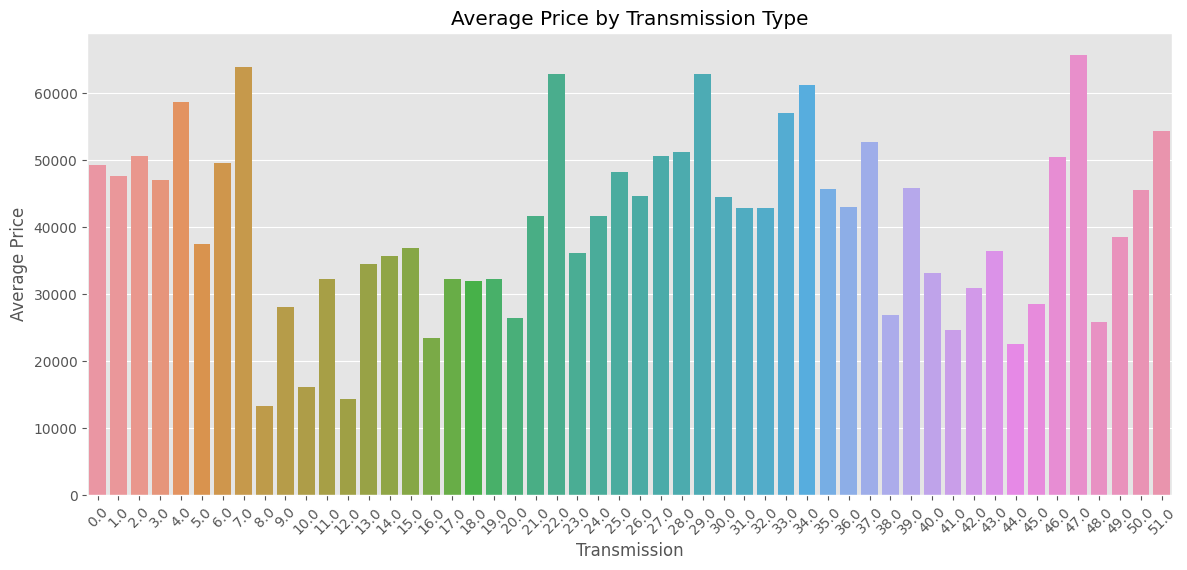

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(x='transmission', y='price', data=df_train_no_outliers, errorbar=None)
plt.title('Average Price by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

# Model Building

In [ ]:
y = df_train['price']
X = df_train.drop(['price'],axis=1)

In [ ]:
df_train.shape

(188533, 15)

In [ ]:
df_test.shape

(125690, 14)

In [ ]:
df_test.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'model_premium', 'is_premium_brand2', 'horsepower'],
      dtype='object')

In [ ]:
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,model_premium,is_premium_brand2,horsepower
0,31.0,495.0,2007.0,213000.0,2.0,116.0,24.0,309.0,67.0,0.0,1.0,4200.0,0.0,0.0,172.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,24.0,260.0,8.0,1.0,1.0,4999.0,0.0,1.0,252.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,24.0,35.0,67.0,0.0,1.0,13900.0,0.0,0.0,320.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,32.0,27.0,12.0,0.0,1.0,45000.0,1.0,1.0,420.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,15.0,27.0,8.0,0.0,1.0,97500.0,0.0,1.0,208.0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X)
scaled_test_data = scaler.transform(df_test)

In [ ]:
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

lgb_params={
                'num_leaves': 426,
                 'max_depth': 20,
                 'learning_rate': 0.011353178352988012,
                 'n_estimators': 10000,
                 'metric': 'rmse',
                 'subsample': 0.5772552201954328,
                 'colsample_bytree': 0.9164865430101521,
                 'reg_alpha': 1.48699088003429e-06,
                 'reg_lambda': 0.41539458543414265,
                 'min_data_in_leaf': 73,
                 'feature_fraction': 0.751673655170548,
                 'bagging_fraction': 0.5120415391590843,
                 'bagging_freq': 2,
                 'random_state': 42,
                 'min_child_weight': 0.017236362383443497,
                 'cat_smooth': 54.81317407769262,
                 'verbose' : -1,
                 'early_stopping_rounds': 200,
}


lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))


for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")

    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm_model = LGBMRegressor(**lgb_params)

    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse',
                   #early_stopping_rounds=10,
                   #verbose=False
                  )


    lgbm_fold_preds = lgbm_model.predict(X_val)
    lgbm_fold_test_preds = lgbm_model.predict(scaled_test_data)

    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits
    fold_rmse = np.sqrt(mean_squared_error(y_val, lgbm_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_lgbm = np.sqrt(mean_squared_error(lgbm_true_labels, lgbm_predictions))
print(f"Overall RMSE (LGBMRegressor): {overall_rmse_lgbm:.4f}")

Training fold 1/3...
Fold 1 RMSE: 65224.0522
Training fold 2/3...
Fold 2 RMSE: 73524.0256
Training fold 3/3...
Fold 3 RMSE: 74367.6529
Overall RMSE (LGBMRegressor): 71158.2608


In [ ]:
#Overall RMSE (LGBMRegressor): 72739.6514
# without feature engineering

In [ ]:
xgb_params={
     'lambda': 0.03880258557285165,
     'alpha': 0.02129832295514386,
     'colsample_bytree': 0.4,
     'subsample': 0.7,
     'learning_rate': 0.014,
     'max_depth': 17,
     'random_state': 2020,
     'min_child_weight': 85,
     'n_estimators': 10000,
     'early_stopping_rounds': 200,
#      'tree_method': 'gpu_hist'

}

n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

xgb_predictions = np.zeros(len(scaled_train_data))
xgb_true_labels = np.zeros(len(scaled_train_data))
xgb_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")

    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='rmse',
                  #early_stopping_rounds=10,
                  verbose=False)

    xgb_fold_preds = xgb_model.predict(X_val)
    xgb_fold_test_preds = xgb_model.predict(scaled_test_data)
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits

    fold_rmse = np.sqrt(mean_squared_error(y_val, xgb_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_xgb = np.sqrt(mean_squared_error(xgb_true_labels, xgb_predictions))
print(f"Overall RMSE (XGBRegressor): {overall_rmse_xgb:.4f}")

Training fold 1/3...
Fold 1 RMSE: 65319.8378
Training fold 2/3...
Fold 2 RMSE: 73926.0555
Training fold 3/3...
Fold 3 RMSE: 74517.3362
Overall RMSE (XGBRegressor): 71378.2486


In [ ]:
#Overall RMSE (XGBRegressor): 72668.3226
#without feature engineering

In [ ]:
xgb_test_predictions

array([16214.71875   , 80351.59570312, 39572.39550781, ...,
       21296.24316406, 17514.20849609, 37134.25      ])

In [ ]:
lgbm_test_predictions

array([17243.48503695, 78840.51039269, 37992.89636485, ...,
       19861.68184029, 14570.29408502, 35968.57885863])

In [ ]:
df_sub['price']= lgbm_test_predictions*0.66+xgb_test_predictions*0.34

## Final submission

In [ ]:
df_sub.to_csv('submission_FE_1.csv', index = False)
pd.read_csv('submission_FE_1.csv')

,id,price
0,188533,43878.016
1,188534,43878.016
2,188535,43878.016
3,188536,43878.016
4,188537,43878.016
...,...,...
125685,314218,43878.016
125686,314219,43878.016
125687,314220,43878.016
125688,314221,43878.016
